<a href="https://colab.research.google.com/github/ZManani/CNN-Neural-Netowrk/blob/master/assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [7]:
dataset = pd.read_csv('/content/housing.csv')
print("Here are the ten rows of the dataset:")
dataset.head(10)

Here are the ten rows of the dataset:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


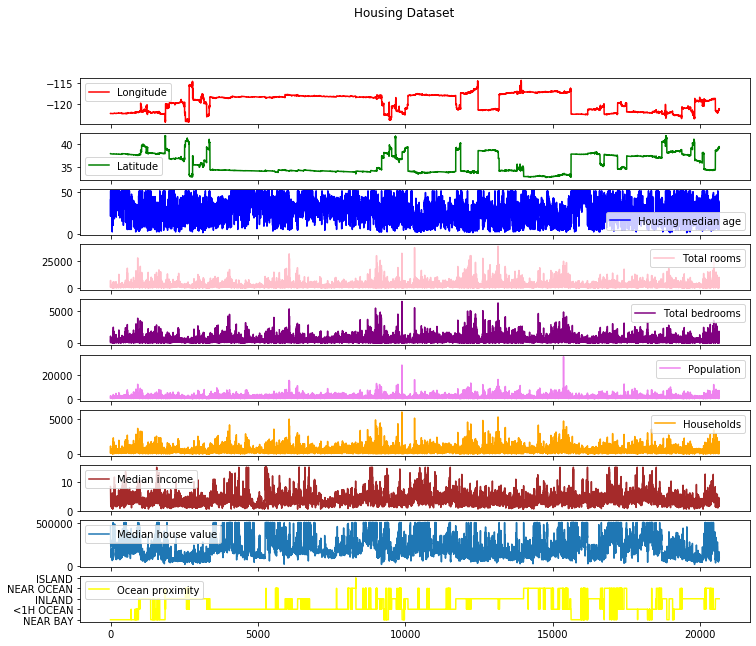

In [8]:
fig, ax = plt.subplots(10, sharex=True, sharey=False, figsize=(12,10))
fig.suptitle('Housing Dataset')
ds=dataset[:]
x_data = range(0, ds.shape[0])
ax[0].plot(x_data,ds['longitude'],color='red',label='Longitude')
ax[0].legend()
ax[1].plot(x_data,ds['latitude'],color='green',label='Latitude')
ax[1].legend()
ax[2].plot(x_data,ds['housing_median_age'],color='blue',label='Housing median age')
ax[2].legend(loc='lower right')
ax[3].plot(x_data,ds['total_rooms'],color='pink',label='Total rooms')
ax[3].legend()
ax[4].plot(x_data,ds['total_bedrooms'],color='purple',label='Total bedrooms')
ax[4].legend()
ax[5].plot(x_data,ds['population'],color='violet',label='Population')
ax[5].legend()
ax[6].plot(x_data,ds['households'],color='orange',label='Households')
ax[6].legend()
ax[7].plot(x_data,ds['median_income'],color='brown',label='Median income')
ax[7].legend()
ax[8].plot(x_data,ds['median_house_value'],label='Median house value')
ax[8].legend()
ax[9].plot(x_data,ds['ocean_proximity'],color='yellow',label='Ocean proximity')
ax[9].legend()

In [0]:
dataset = dataset.dropna()
Y = dataset['median_house_value']
X = dataset.loc[:,'longitude':'median_income']

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state= 2003)
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()
x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()
print("There are " + str(x_train.size) + " training entries and " +str(x_test.size) + " testing entries!")

There are 114424 training entries and 49040 testing entries!


In [0]:
import torch
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset

In [0]:
class CnnRegressor(torch.nn.Module):
  def __init__(self, batch_size, inputs, outputs):
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs
    print("inputs"+str(self.inputs))
    self.input_layer = Conv1d(inputs, batch_size, 1)
    self.max_pooling_layer = MaxPool1d(1)
    print(self.max_pooling_layer)
    self.conv_layer = Conv1d(batch_size, 128, 1)
    self.flatten_layer = Flatten()
    self.linear_layer = Linear(128, 64)
    self.output_layer = Linear(64, outputs)
  def feed(self, input):
    input = input.reshape((self.batch_size, self.inputs, 1))
    output = relu(self.input_layer(input))
    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer(output))
    output = self.flatten_layer(output)
    output = self.linear_layer(output)
    output = self.output_layer(output)
    return output

In [13]:
from torch.optim import Adam
from torch.nn import MSELoss
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

     |████████████████████████████████| 112kB 11.6MB/s 


In [14]:
batch_size = 64
print("shape is"+str(X.shape))
model = CnnRegressor(batch_size,X.shape[1],1)
model.cuda()

shape is(20433, 8)
inputs8
MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)


CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
def model_loss(model, dataset, train = False, optimizer = None):
  performance = MSELoss()
  score_metric = R2Score()
  avg_loss = 0
  avg_score = 0
  count = 0
  for input, output in iter(dataset):
    predictions = model.feed(input)
    loss = performance(predictions, output)
    score_metric.update([predictions, output])
    score = score_metric.compute()
    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    avg_loss += loss.item()
    avg_score += score
    count += 1
  return avg_loss / count, avg_score / count



In [16]:
epochs=500
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
for epoch in range(epochs):
  avg_loss, avg_r2_score = model_loss(model, loader, train=True, optimizer=optimizer)
  print("Epoch " + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + "\n\tR^2 Score = " + str(avg_r2_score))
 

Epoch 1:
	Loss = 32970617217.721973
	R^2 Score = -2.1617104518359462
Epoch 2:
	Loss = 22626487217.93722
	R^2 Score = -0.8399300463430737
Epoch 3:
	Loss = 13204222631.605381
	R^2 Score = -0.12399085219199325
Epoch 4:
	Loss = 10725230277.452915
	R^2 Score = 0.17865760424457017
Epoch 5:
	Loss = 10287639770.116592
	R^2 Score = 0.22621830897090853
Epoch 6:
	Loss = 9829240446.278027
	R^2 Score = 0.25291430617266386
Epoch 7:
	Loss = 9344899342.923767
	R^2 Score = 0.2959397873701906
Epoch 8:
	Loss = 8939943084.19731
	R^2 Score = 0.3207813992644957
Epoch 9:
	Loss = 8510283307.623319
	R^2 Score = 0.3620270423279926
Epoch 10:
	Loss = 8214050590.995516
	R^2 Score = 0.37595120878537214
Epoch 11:
	Loss = 7890170923.623319
	R^2 Score = 0.39520233243491426
Epoch 12:
	Loss = 7755750895.928251
	R^2 Score = 0.4060149078036546
Epoch 13:
	Loss = 7572829328.64574
	R^2 Score = 0.4288627608125275
Epoch 14:
	Loss = 7363486315.910314
	R^2 Score = 0.44781172881200104
Epoch 15:
	Loss = 7231734468.304933
	R^2 Scor

In [17]:
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
avg_loss, avg_r2_score = model_loss(model, loader)
print("The model's MSE loss is: " + str(avg_loss))
print("The model's R^2 score is: " + str(avg_r2_score))

The model's MSE loss is: 4132247076.3789473
The model's R^2 score is: 0.709461796718675


In [18]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
avg_loss, avg_r2_score = model_loss(model, loader)
end.record()

torch.cuda.synchronize()

print(start.elapsed_time(end))

114.33168029785156


In [20]:
trained_model = {'model': CnnRegressor(64,8,1),
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict()}
torch.save(trained_model, '1105524_1dconv_reg')

inputs8
MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CnnRegressor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# New Section